In [162]:
import pandas as pd
from pathlib import Path
import hvplot.pandas
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from fbprophet import Prophet
import os
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi


In [163]:
load_dotenv()

True

In [164]:
alpaca_api_key = os.getenv('ALPACA_API_KEY')
alpaca_secret_key = os.getenv('ALPACA_SECRET_KEY')

alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version='v2'
)

In [165]:
tweets_df = pd.read_csv(
    Path('stock_market_crash_2022.csv'),
    index_col='created_at',
    infer_datetime_format=True,
    parse_dates=True
)
tweets_df.index = tweets_df.index.date
tweets_df.head()

,id,text,text_sentiment,username,hashtags,user followers count,replycount,retweetcount,likecount,quotecount,language,media,retweetedTweet,quotedtweet,inReplyToTweetId,inReplyToUser,mentionedUsers
2022-06-19,1538666561615015938,When will the #NYSE #stockmarketcrash happen?,Neutral,tradexlnc,"['NYSE', 'stockmarketcrash']",10669,0,0,1,0,en,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-19,1538665013799489536,Aaj ka gyan:\n\nIf a company isn't a quality c...,Negative,niftymonday,"['stockmarkets', 'stockmarketcrash', 'trading'...",100,0,1,8,0,en,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-19,1538660868027830274,The stock market needs to crash hard to make i...,Negative,kyle132313,"['stockmarketcrash', 'economy', 'rich', 'Fed']",0,0,0,0,0,en,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-19,1538657239849836544,"Those who are ""Buying on DIP"" will very soon b...",Neutral,ChintanRajput16,"['stockmarketcrash', 'StocksToBuy', 'stockstow...",54,0,2,2,0,en,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-19,1538654339044196358,@rdrhwke I wish our so-called President were t...,Positive,DrPCJustice,"['Bidenomics', 'inflation', 'recession', 'stoc...",28,0,0,0,0,en,NaN,NaN,NaN,1.538653e+18,https://twitter.com/rdrhwke,"[User(username='rdrhwke', id=43753976, display..."


In [166]:
sentiment_df = pd.DataFrame()
sentiment_df['sentiment'] = tweets_df[['text_sentiment']]
sentiment_df

,sentiment
2022-06-19,Neutral
2022-06-19,Negative
2022-06-19,Negative
2022-06-19,Neutral
2022-06-19,Positive
...,...
2022-01-02,Neutral
2022-01-02,Neutral
2022-01-02,Positive
2022-01-02,Positive


In [167]:
sentiment_ordering = ['Negative', 'Neutral', 'Positive']
sentiment_df['sentiment'] = sentiment_df['sentiment'].apply(lambda x: sentiment_ordering.index(x))
sentiment_df

,sentiment
2022-06-19,1
2022-06-19,0
2022-06-19,0
2022-06-19,1
2022-06-19,2
...,...
2022-01-02,1
2022-01-02,1
2022-01-02,2
2022-01-02,2


In [168]:
sentiment_df['date'] = pd.to_datetime(sentiment_df.index)
sentiment_df.dtypes

sentiment             int64
date         datetime64[ns]
dtype: object

In [169]:
sentiment_df

,sentiment,date
2022-06-19,1,2022-06-19
2022-06-19,0,2022-06-19
2022-06-19,0,2022-06-19
2022-06-19,1,2022-06-19
2022-06-19,2,2022-06-19
...,...,...
2022-01-02,1,2022-01-02
2022-01-02,1,2022-01-02
2022-01-02,2,2022-01-02
2022-01-02,2,2022-01-02


In [171]:
daily_sentiment = sentiment_df.groupby(sentiment_df.date.dt.date).mean()
daily_sentiment


,sentiment
date,
2022-01-01,2.000000
2022-01-02,1.157895
2022-01-03,1.047619
2022-01-04,0.769231
2022-01-05,0.894737
...,...
2022-06-15,1.143524
2022-06-16,1.063039
2022-06-17,1.096569


In [110]:
ticker = ['BTCUSD']
start_date = daily_sentiment.index.min()
end_date = daily_sentiment.index.max()
timeframe = '1Day'

In [111]:
crypto_df = alpaca.get_crypto_bars(
    ticker,
    timeframe,
    start_date,
    end_date,
    limit = 10000,
    exchanges = 'CBSE' 
    ).df
crypto_df = crypto_df[['close']]
crypto_df.index = crypto_df.index.date
crypto_df

,close
2022-01-01,47093.40
2022-01-02,47090.32
2022-01-03,46157.15
2022-01-04,46304.01
2022-01-05,43047.13
...,...
2022-06-15,22072.04
2022-06-16,20510.76
2022-06-17,20455.24
2022-06-18,18486.41


In [112]:
data_df = pd.concat([daily_sentiment, crypto_df], axis=1)
data_df

,sentiment,close
2022-01-01,2.000000,47093.40
2022-01-02,1.157895,47090.32
2022-01-03,1.047619,46157.15
2022-01-04,0.769231,46304.01
2022-01-05,0.894737,43047.13
...,...,...
2022-06-15,1.143524,22072.04
2022-06-16,1.063039,20510.76
2022-06-17,1.096569,20455.24
2022-06-18,1.154830,18486.41


In [149]:
features_df = data_df.reset_index()[['index', 'sentiment', 'close']].rename({'index':'ds','close':'y','sentiment':'sentiment'},axis='columns')
features_df['1d ago'] = data_df['close'].shift(1).values
features_df['2d ago'] = data_df['close'].shift(2).values
features_df = features_df.dropna()


In [150]:
df_train = features_df.loc[:117]
df_train

,ds,sentiment,y,1d ago,2d ago
2,2022-01-03,1.047619,46157.15,47090.32,47093.40
3,2022-01-04,0.769231,46304.01,46157.15,47090.32
4,2022-01-05,0.894737,43047.13,46304.01,46157.15
5,2022-01-06,1.183333,41834.30,43047.13,46304.01
6,2022-01-07,0.950000,41977.37,41834.30,43047.13
...,...,...,...,...,...
113,2022-04-24,1.100000,39160.56,39721.32,39542.76
114,2022-04-25,1.033333,40568.09,39160.56,39721.32
115,2022-04-26,1.169492,38408.14,40568.09,39160.56
116,2022-04-27,1.145455,39397.55,38408.14,40568.09


In [115]:
df_test = features_df.loc[117:]
df_test

,ds,sentiment,y,1d ago,2d ago
117,2022-04-28,1.000000,39532.21,39397.55,38408.14
118,2022-04-29,1.148148,38564.33,39532.21,39397.55
119,2022-04-30,1.058824,37963.72,38564.33,39532.21
120,2022-05-01,1.360000,38973.42,37963.72,38564.33
121,2022-05-02,1.102041,38491.16,38973.42,37963.72
122,2022-05-03,1.222222,37976.48,38491.16,38973.42
123,2022-05-04,1.145833,39728.88,37976.48,38491.16
124,2022-05-05,1.041096,36414.66,39728.88,37976.48
125,2022-05-06,1.086726,35760.77,36414.66,39728.88
126,2022-05-07,1.024272,34390.10,35760.77,36414.66


In [173]:
m = Prophet(yearly_seasonality=True,daily_seasonality=True)
# m.add_regressor('sentiment')
# m.add_regressor('1d ago')
# m.add_regressor('2d ago')
m.fit(df_train)

In [174]:
future = m.make_future_dataframe(periods=52, freq='d')
#future = pd.concat([df_train.drop(columns ='ds'), future], axis=1)
future


,ds
0,2022-01-03
1,2022-01-04
2,2022-01-05
3,2022-01-06
4,2022-01-07
...,...
163,2022-06-15
164,2022-06-16
165,2022-06-17
166,2022-06-18


In [147]:
forecast = m.predict(future)

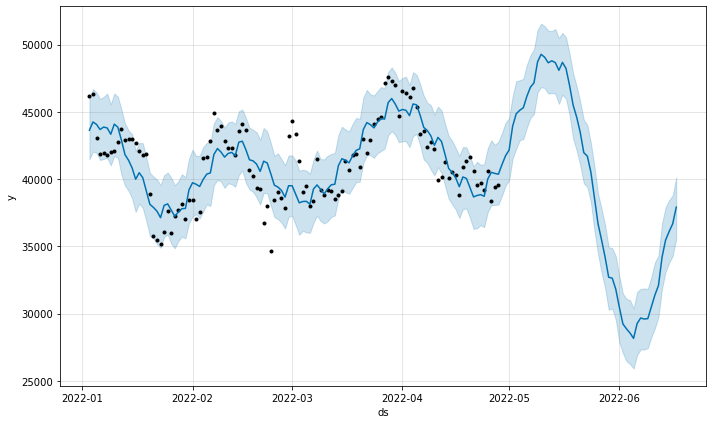

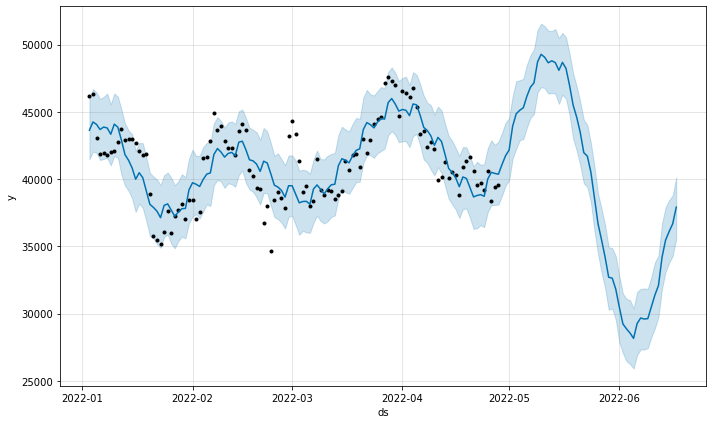

In [141]:
m.plot(forecast)

In [151]:
from sklearn.metrics import mean_absolute_error
y_actual = features_df['y']
y_predicted = forecast['yhat']
y_predicted = y_predicted.astype(int)
mean_absolute_error(y_actual, y_predicted)

3960.4369047619043